In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import transformations as tf
import matplotlib.pyplot as plt
import pcl
import os
import os.path as osp

In [5]:
BASE_PATH = './data/tree2/run1/viorb_log'
keyframes = pd.read_csv(osp.join(BASE_PATH, 'keyframes_with_id.txt'), sep=' ')
objects = pd.read_csv(osp.join(BASE_PATH,'objects.txt'), sep=' ')
benchmark = pd.read_csv(osp.join(BASE_PATH,'benchmark.csv'))
# Loaded as XYZ pointclouds
map_cloud = pcl.load(osp.join(BASE_PATH, 'map.pcd'))
# object clouds
obj_clouds = {}
for i in objects['#id']:
    obj_clouds[i] = pcl.load(osp.join(BASE_PATH, 'object_pointclouds', '{}.pcd'.format(i)))

In [7]:
benchmark['diameter'] = benchmark[['perimeter']].apply(lambda x: x / np.pi)

In [8]:
benchmark

,#id,perimeter,associate_id,diameter
0,1,2.460,0,0.783042
1,2,1.995,1,0.635028
2,3,1.710,2,0.544310
3,4,1.850,3,0.588873
4,5,1.480,5,0.471099
5,6,1.860,-1,0.592056
6,7,2.500,6,0.795775


In [9]:
def add_tf_mat_to_df(df, use_shift_centroid=False):
    try:
        df.drop(columns=['T'])
    except KeyError:
        pass
    
    def _get_tf_mat_from_row(drow):
        q = np.array(drow[['qw', 'qx', 'qy', 'qz']])
        t = None
        if use_shift_centroid:
            t = np.array(drow[['x_cloud', 'y_cloud', 'z_cloud']]).reshape(3)  
        else:
            t = np.array(drow[['x', 'y', 'z']]).reshape(3)
        T = tf.quaternion_matrix(q)
        T[:3, 3] = t
        return T

    df['T'] = df.apply(_get_tf_mat_from_row, axis=1)

def transform_cloud(T, points):
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(T, points_homo)
    return np.transpose(outs)[:, :3]

# Transform all points to local
def get_local_points(Two, points):
    Tow = np.linalg.inv(Two)
    points_homo = np.ones((points.shape[0], 4))
    points_homo[:,:3] = points
    points_homo = np.transpose(points_homo)
    outs = np.matmul(Tow, points_homo)
    return np.transpose(outs)[:, :3]

def add_shift_centroid_data(objects, obj_clouds):
    results = []
    results_cols = ['#id', 'x_cloud', 'y_cloud', 'z_cloud']
    for i, cloud in obj_clouds.items():
        cloud_arr = np.asarray(cloud)
        centroid = np.mean(cloud_arr, axis=0)
        # TODO -- find boundary using PCA
        results.append((i, *centroid))

    df = pd.DataFrame(results, columns=results_cols)
    return pd.merge(objects, df, on='#id')

In [10]:
USE_SHIFT_CENTROID=False
objects = add_shift_centroid_data(objects, obj_clouds)
add_tf_mat_to_df(objects, use_shift_centroid=USE_SHIFT_CENTROID)

In [62]:
USE_SHIFT_CENTROID=False

,#id,label,x,y,z,qx,qy,qz,qw,sx,sy,sz,x_cloud,y_cloud,z_cloud,T
0,0,0,2.137294,0.601331,3.877034,0.584839,-0.324283,0.396349,0.629056,0.431192,0.479107,0.087841,1.944592,0.449677,3.265885,"[[0.47549606516709875, -0.8779580353347702, 0...."
1,1,0,4.381115,0.915378,5.465585,0.601855,-0.291490,0.361005,0.649984,0.666446,0.372832,0.098058,4.190695,0.870445,5.126884,"[[0.569417798263272, -0.8201646452411815, 0.05..."


In [11]:
def get_value_by_id(df, id, col_name):
    return objects[objects['#id'] == id][col_name][0]

def get_row_by_id(df, id):
    return objects[objects['#id'] == id].iloc[0]

In [7]:
# Transform mappoints to first object (id=0) frame ref
Tw0 = objects[objects['#id'] == 0]['T'][0]
map_cloud_0 = pcl.PointCloud(get_local_points(Tw0, np.asarray(map_cloud)).astype(np.float32))

In [8]:
pcl.save(map_cloud_0, 'world.pcd')

In [12]:
def _get_cloud_in_box(cloud, size_xy, height_min, height_max, origin):
    # TODO -- fix this using numpy all
    out = cloud

    # Filter X
    out = out[ out[:, 0] >= origin[0] - size_xy[0]]
    out = out[ out[:, 0] <= origin[0] + size_xy[0]]

    # Filter Y
    out = out[ out[:, 1] >= origin[1] - size_xy[1]]
    out = out[ out[:, 1] <= origin[1] + size_xy[1]]

    # Filter Height
    out = out[ out[:, 2] >= origin[2] - height_min ]
    out = out[ out[:, 2] <= origin[2] + height_max ]

    return out

# # TODO -- fix this!
# def get_tree_cloud_in_objects(map_cloud, objects, height=5.0, height_min=0.5, size_xy=None):
#     outcloud = {}
#     map_cloud_raw = np.asarray(map_cloud)
#     if size_xy is not None:
#         assert(len(size_xy) == 2)
    
#     for i in objects['#id']:
#         s_size = [0,0]
#         obj = get_row_by_id(objects, i)
#         T_ref0 = obj['T_ref0']
#         t = T_ref0[:3, 3] # centroid
#         print(t)
#         if size_xy is None:
#             s_size[0] = obj['sx']
#             s_size[1] = obj['sy']
#         else:
#             s_size = size_xy
        
#         tmp_cloud = _get_cloud_in_box(map_cloud_raw, size_xy, height_min, height, t)

#         outcloud[i] = pcl.PointCloud(tmp_cloud.astype(np.float32))

#     return outcloud

In [63]:
# get from world
def naive_get_tree_cloud_in_objects(map_cloud, objects, height=5.0, height_min=0.5, size_xy=None):
    outcloud = {}
    map_cloud_raw = np.asarray(map_cloud)
    if size_xy is not None:
        assert(len(size_xy) == 2)
    
    for i in objects['#id']:
        s_size = [0,0]
        obj = get_row_by_id(objects, i)
        T_ref0 = obj['T']
        t = (0,0,0) # centroid
        if size_xy is None:
            s_size[0] = obj['sx']
            s_size[1] = obj['sy']
        else:
            s_size = size_xy
        map_cloud_local = get_local_points(T_ref0, map_cloud_raw)
        tmp_cloud = _get_cloud_in_box(map_cloud_local, s_size, height_min, height, t)

        outcloud[i] = pcl.PointCloud(tmp_cloud.astype(np.float32))

    return outcloud

In [14]:
# For visualization purpose
def reconstruct_world_cloud(tree_clouds, objects, ref_id=None):
    out = []
    for i, cloud in tree_clouds.items():
        obj = get_row_by_id(objects, i)
        icloud = transform_cloud(obj['T'], np.asarray(cloud))
        out.append(icloud)
    
    outcloud = np.concatenate(out, axis=0)

    if ref_id is None:
        return pcl.PointCloud(outcloud.astype(np.float32))

    ref_obj = get_row_by_id(objects, ref_id)
    refcloud = get_local_points(ref_obj['T'], outcloud)

    return pcl.PointCloud(refcloud.astype(np.float32))

# Same as above but split for each object
def reconstruct_each_object_clouds_world(tree_clouds, objects, ref_id=None):
    out = {}
    ref_obj=None
    if ref_id is not None:
        ref_obj = get_row_by_id(objects, ref_id)
    
    for i, cloud in tree_clouds.items():
        obj = get_row_by_id(objects, i)
        icloud = transform_cloud(obj['T'], np.asarray(cloud))
        if ref_id is None:
            out[i] = pcl.PointCloud(icloud.astype(np.float32))
        else:
            refcloud = get_local_points(ref_obj['T'], icloud)
            out[i] = pcl.PointCloud(refcloud.astype(np.float32))
    return out

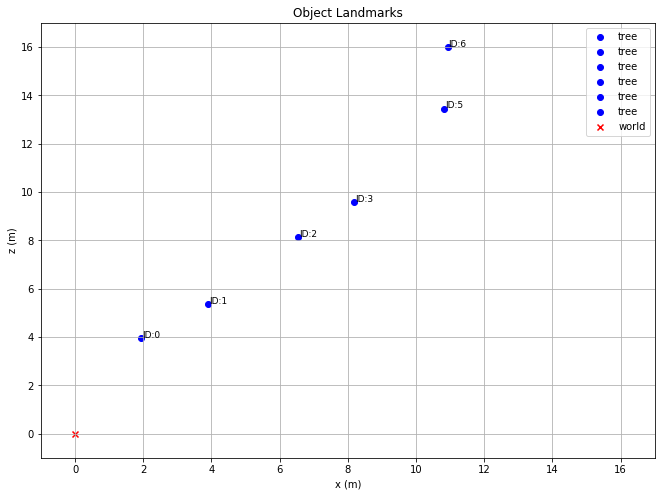

In [20]:
# Plot 2d Object in Ref ID cooridinate
REF_ID=0
plt.figure(figsize=(11,8))
plt.ylabel('z (m)')
plt.xlabel('x (m)')
plt.title('Object Landmarks')
plt.grid(True)
# # Draw object center
# centroids = None
# if USE_SHIFT_CENTROID:
#     centroids = objects[['#id','x_cloud', 'y_cloud', 'z_cloud']]
# else:
#     centroids = objects[['#id','x', 'y', 'z']]

# T_ref = objects[objects['#id'] == REF_ID].iloc[0]['T']
# origin
# origin_ref = np.matmul(T_ref, np.array([0,0,0,1]).T)[:2]

# points_data = np.asarray(centroids)
# centroids_ref = get_local_points(T_ref, points_data[:, 1:])
# out = np.zeros((points_data.shape[0], 3)) #id, x, y
# out[:, 0] = points_data[:, 0]
# out[:, 1:] = points_data[:, 1:3]
plt.xlim(-1, 17)
plt.ylim(-1, 17)

centroids = objects[['#id','x', 'z']]
for idx, r in objects[['#id', 'x', 'z']].iterrows():
    plt.scatter(r['x'], r['z'], marker='o', color='b', label='tree')
    plt.text(r['x']+.03, r['z']+.03, 'ID:{}'.format(int(r['#id'])), fontsize=9)



# plot origin
plt.scatter(0, 0, marker='x', color='r', label='world')


# plt.plot(objects['x'][IDX], objects['z'][IDX], 'ro', color='b', label='objects')

plt.legend()


In [18]:
objects[['#id', 'x', 'z']]

,#id,x,z
0,0,1.940682,3.946565
1,1,3.905308,5.357088
2,2,6.539523,8.119213
3,3,8.183582,9.588652
4,5,10.828942,13.444711
5,6,10.924343,15.985823


In [17]:
for idx, r in objects[['#id', 'x', 'z']].iterrows():
    print(r)


#id    0.000000
x      1.940682
z      3.946565
Name: 0, dtype: float64
#id    1.000000
x      3.905308
z      5.357088
Name: 1, dtype: float64
#id    2.000000
x      6.539523
z      8.119213
Name: 2, dtype: float64
#id    3.000000
x      8.183582
z      9.588652
Name: 3, dtype: float64
#id     5.000000
x      10.828942
z      13.444711
Name: 4, dtype: float64
#id     6.000000
x      10.924343
z      15.985823
Name: 5, dtype: float64


In [25]:
recon_each

{0: <PointCloud of 495 points>,
 1: <PointCloud of 1018 points>,
 2: <PointCloud of 701 points>,
 3: <PointCloud of 673 points>,
 5: <PointCloud of 659 points>,
 6: <PointCloud of 542 points>}

In [83]:
OBJECT_ID = 0
# Coarse SOR
obj = get_row_by_id(objects, OBJECT_ID)
fil = tree_clouds[OBJECT_ID].make_statistical_outlier_filter()
fil.set_mean_k(40)
fil.set_std_dev_mul_thresh(1.            print('I AM HERE')0)
step0_inliers = fil.filter()
pcl.save(step0_inliers, 'step0.pcd')

# Remove trunk
fil = step0_inliers.make_passthrough_filter()
fil.set_filter_field_name('z')
fil.set_filter_limits(obj['sz']*2, 99.0)
step1_inliers = fil.filter()
pcl.save(step1_inliers, 'step1.pcd')

# Smooth cylinder surface
fil = step1_inliers.make_moving_least_squares()
fil.set_search_radius(0.4)
fil.set_polynomial_order(2)
step2_inliers = fil.process()
pcl.save(step2_inliers, 'step2.pcd')

# Fine SOR
fil = step2_inliers.make_statistical_outlier_filter()
fil.set_mean_k(5)
fil.set_std_dev_mul_thresh(1.0)
step3_inliers = fil.filter()
pcl.save(step3_inliers, 'step3.pcd')

# SAC_cylinder extraction (not work)
# seg = step3_inliers.make_segmenter_normals()
# seg.set_optimize_coefficients(True)
# seg.set_model_type(pcl.SACMODEL_CYLINDER)
# seg.set_method_type(pcl.SAC_RANSAC)
# seg.set_max_iterations(10000)
# seg.set_normal_distance_weight(0.1)
# seg.set_distance_threshold(1) # this is quite sparse pointclouds
# seg.set_axis(0,0,1)
# indices, model = seg.segment()

In [79]:
def post_process_tree_cloud(tree, sz):
    # Coarse SOR
    fil = tree.make_statistical_outlier_filter()
    fil.set_mean_k(40)
    fil.set_std_dev_mul_thresh(1.0)
    step0_inliers = fil.filter()
    # Remove trunk
    fil = step0_inliers.make_passthrough_filter()
    fil.set_filter_field_name('z')
    fil.set_filter_limits(sz*2, 99.0)
    step1_inliers = fil.filter()
    # Smooth cylinder surface
    fil = step1_inliers.make_moving_least_squares()
    fil.set_search_radius(0.3)
    fil.set_polynomial_order(2)
    step2_inliers = fil.process()
    # Fine SOR
    fil = step2_inliers.make_statistical_outlier_filter()
    fil.set_mean_k(10)
    fil.set_std_dev_mul_thresh(0.7)
    step3_inliers = fil.filter()
    return step3_inliers

# Assume that trunk and outliers are completely eliminate
def get_approx_diameter(cloud):
    cloud_array = np.asarray(cloud)
    bound_mins = np.min(cloud_array, axis=0)
    bound_maxs = np.max(cloud_array, axis=0)
    size_x = bound_maxs[0] - bound_mins[0]
    size_y = bound_maxs[1] - bound_mins[1]
    return np.max((size_x, size_y))

def _get_middle_chunk(cloud_array, percent_cut=0.4):
    # find middle chunk along z
    z_min = np.min(cloud_array[:,2])
    z_max = np.max(cloud_array[:,2])
    z_size = (z_max - z_min) / 2.0
    centroid = np.mean(cloud_array, axis=0)
    z_th_upper = centroid[2] + (z_size * percent_cut)
    z_th_lower = centroid[2] - (z_size * percent_cut)
    cloud_array_inliers = cloud_array[ cloud_array[:, 2] < z_th_upper]
    cloud_array_inliers = cloud_array_inliers[ cloud_array_inliers[:, 2] > z_th_lower]

    return cloud_array_inliers

def get_approx_diameter_middle_chunk(cloud, percent_cut=0.4):
    cloud_array = np.asarray(cloud)
    cloud_array_inliers = _get_middle_chunk(cloud_array)

    return get_approx_diameter(cloud_array_inliers)

In [148]:
# obj = get_row_by_id(objects, 0)
# cloud = post_process_tree_cloud(tree_clouds[0], obj['sz'])
# print(get_approx_diameter(cloud))
# print(get_approx_diameter_middle_chunk(cloud))

1.0453691
0.8730954


In [48]:
from sklearn.decomposition import PCA
import scipy

def calculate_ellipse_perimeter(a,b):
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

def get_ellipse_params(dataProject, conf=0.95):
    theta = np.concatenate((np.linspace(-np.pi, np.pi, 50), np.linspace(np.pi, -np.pi, 50)))
    circle = np.array((np.cos(theta), np.sin(theta)))
    sigma = np.cov(np.array((dataProject[:, 0], dataProject[:, 1])))
    ed = np.sqrt(scipy.stats.chi2.ppf(conf, 2))
    ell = np.transpose(circle).dot(np.linalg.cholesky(sigma) * ed)
    a, b = np.max(ell[: ,0]), np.max(ell[: ,1]) #95% ellipse bounds
    return a, b

def get_approx_circumfence_pca(cloud, ellipse_conf=0.95, percent_cut=-1.0):
    # from 2D projection only
    cloud_array = np.asarray(cloud)
    if percent_cut > 0:
        cloud_array = _get_middle_chunk(cloud_array, percent_cut)
    cloud_2d = cloud_array[:, :2]
    pca = PCA(2)
    pca.fit(cloud_2d)
    out = pca.transform(cloud_2d)
    a, b = get_ellipse_params(out, ellipse_conf)
    ell_p = calculate_ellipse_perimeter(a, b)
    size_min = np.min(out, axis=0)
    size_max = np.max(out, axis=0)
    scale_out = (size_max - size_min)
    scale_p = np.pi * np.max(scale_out)
    dia = get_approx_diameter(cloud_array)
    dia_p = np.pi * dia
    result = {
        'ellipse': (a, b),
        'ellipse_perimeter': ell_p,
        'pca_scale': scale_out,
        'pca_diameter': np.max(scale_out),
        'pca_perimeter': scale_p,
        'approx_diameter': dia,
        'approx_perimeter': dia_p
    }

    return result, out


In [80]:
# DO NOT USE map_cloud_0, use world
# tree_clouds = naive_get_tree_cloud_in_objects(map_cloud, objects, size_xy=(1.5,1.5), height_min=0, height=2.5)
tree_clouds = naive_get_tree_cloud_in_objects(map_cloud, objects, size_xy=(1.0, 1.0),height_min=0, height=1.5)
recon = reconstruct_world_cloud(tree_clouds, objects, ref_id=0)
recon_each = reconstruct_each_object_clouds_world(tree_clouds, objects, ref_id=0)
pcl.save(recon, 'recon.pcd')

In [69]:
tree_clouds

{0: <PointCloud of 442 points>,
 1: <PointCloud of 778 points>,
 2: <PointCloud of 608 points>,
 3: <PointCloud of 557 points>,
 5: <PointCloud of 394 points>,
 6: <PointCloud of 344 points>}

### Run Final result !

In [83]:
out_post_process = {}
data_out = []
pca_points = {}
PCA_CONFIDENCE=0.85
MIDDLE_CHUNK_PERCENT_CUT = 0.3
for i, cloud in tree_clouds.items():
    obj = get_row_by_id(objects, i)
    cloud = post_process_tree_cloud(cloud, obj['sz'])
    out_post_process[i] = cloud
    result, tf_points = get_approx_circumfence_pca(cloud, PCA_CONFIDENCE, MIDDLE_CHUNK_PERCENT_CUT)
    result['#id'] = i
    data_out.append(result)
    pca_points[i] = tf_points

results_df = pd.DataFrame(data_out)

In [82]:
# reconstruction
recon2 = reconstruct_world_cloud(out_post_process, objects, ref_id=0)
pcl.save(recon2, 'post_recon.pcd')

In [84]:
results_df


,#id,approx_perimeter,approx_scale,ellipse,ellipse_perimeter,scale,scale_perimeter
0,0,1.885790,0.600266,"(0.3232914187866048, 0.13682836307999102)",1.505479,"[0.6225753, 0.26402357]",1.955878
1,1,3.255703,1.036322,"(0.5073819215896404, 0.37227570197102855)",2.779848,"[0.9266962, 0.7030733]",2.911302
2,2,2.107083,0.670705,"(0.3345141016040204, 0.2622880470690226)",1.881781,"[0.6458271, 0.55794615]",2.028926
3,3,2.077964,0.661437,"(0.32502074667237885, 0.06714404455410572)",1.369012,"[0.6642193, 0.20662102]",2.086707
4,5,1.708080,0.543699,"(0.3275573055417421, 0.1807671047265883)",1.630416,"[0.56881326, 0.35643613]",1.786980
5,6,3.837985,1.221668,"(0.5458404425324526, 0.48003987420711647)",3.226214,"[0.9197991, 1.0833321]",3.403388


In [51]:
benchmark

,#id,perimeter,associate_id,diameter
0,1,2.460,0,0.783042
1,2,1.995,1,0.635028
2,3,1.710,2,0.544310
3,4,1.850,3,0.588873
4,5,1.480,5,0.471099
5,6,1.860,-1,0.592056
6,7,2.500,6,0.795775


In [53]:
cloud0 = np.asarray(out_post_process[1])
cloud0[:, :2]
pca = PCA(2)
pca.fit(cloud0[:, :2])
out = pca.transform(cloud0[:, :2])

In [54]:
print(np.min(out, axis=0))
print(np.max(out, axis=0))

[-0.5938152  -0.26567024]
[0.88924    0.55509883]


In [50]:
import scipy

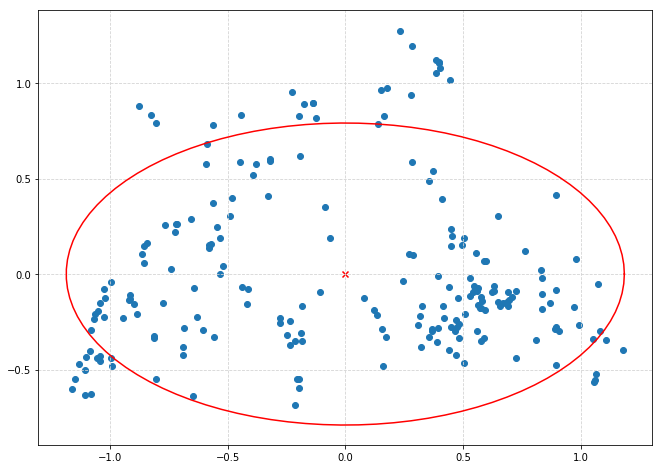

In [52]:
dataProject = pca_points[6]
plt.figure(figsize=(11,8))
plt.grid(True)
plt.scatter(dataProject[:,0], dataProject[:,1])
plt.scatter(0, 0, marker='x', color='r')
# Plot ellipse
theta = np.concatenate((np.linspace(-np.pi, np.pi, 50), np.linspace(np.pi, -np.pi, 50)))
circle = np.array((np.cos(theta), np.sin(theta)))
sigma = np.cov(np.array((dataProject[:, 0], dataProject[:, 1])))
ed = np.sqrt(scipy.stats.chi2.ppf(0.8, 2))
ell = np.transpose(circle).dot(np.linalg.cholesky(sigma) * ed)
a, b = np.max(ell[: ,0]), np.max(ell[: ,1]) #95% ellipse bounds
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(a * np.cos(t), b * np.sin(t), color = 'red')
plt.grid(color = 'lightgray', linestyle = '--')



[[-0.5269774  0.8498792]
 [ 0.8498792  0.5269774]]
[0.0345585  0.01481814]


In [60]:
np.sqrt(2)

1.4142135623730951

In [129]:
objects

,#id,label,x,y,z,qx,qy,qz,qw,sx,sy,sz,T,T_ref0
0,0,0,2.137294,0.601331,3.877034,0.584839,-0.324283,0.396349,0.629056,0.431192,0.479107,0.087841,"[[0.47549606516709875, -0.8779580353347702, 0....","[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."
1,1,0,4.381115,0.915378,5.465585,0.601855,-0.291490,0.361005,0.649984,0.666446,0.372832,0.098058,"[[0.569417798263272, -0.8201646452411815, 0.05...","[[0.2707559225102987, -0.09788232827841803, 0...."


In [122]:
tf.transformations.inverse_matrix(objects['T_ref0'].iloc[1])[:, 3]

array([ 77.67544699,   6.5171438 , -16.95360563,   1.        ])

In [131]:
tf.transformations.translation_from_matrix(objects['T_ref0'].iloc[1])

array([-1.95713391e+01,  1.77010514e-02,  3.75587035e-01])

Cylinder extraction params
http://docs.pointclouds.org/trunk/group__sample__consensus.html